In [1]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append("../../../../")
from analysis_functions import *

In [2]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [3]:
component_num = 0

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    loss="squared_error",
    random_state=RANDOM_STATE,
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")


RMSE test: 15.11
RMSE train: 15.13


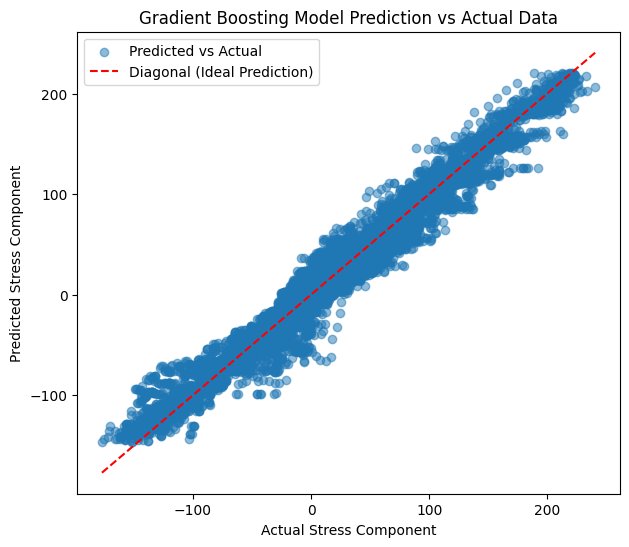

In [17]:
import matplotlib.pyplot as plt

# Predicting the values
cur_y_pred = model.predict(cur_X_test)

# Plotting the results
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Gradient Boosting Model Prediction vs Actual Data")
plt.legend()
plt.show()

## С оптимизацией гиперпараметров

In [4]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)


In [ ]:
def do_optuna_for_boosting(X, y, n_trials=200, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_boosting_val(trial):
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

        params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = GradientBoostingRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_boosting_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value


# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_boosting(X, y, n_splits=n_splits)

# Предсказание
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
model.fit(cur_X_train, cur_y_train)
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")


[I 2025-05-16 15:08:00,824] A new study created in memory with name: no-name-b3faf02d-5bf2-4266-b983-10221020fb8b
[I 2025-05-16 15:08:02,433] Trial 6 finished with value: 37.700790000560715 and parameters: {'n_estimators': 74, 'max_depth': 1, 'learning_rate': 0.04061540548935095}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:06,551] Trial 1 finished with value: 53.96333841467704 and parameters: {'n_estimators': 77, 'max_depth': 5, 'learning_rate': 0.005137742420778619}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:07,694] Trial 4 finished with value: 66.61098427805649 and parameters: {'n_estimators': 143, 'max_depth': 3, 'learning_rate': 0.0012534476953072636}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:08:09,342] Trial 0 finished with value: 70.32179551799547 and parameters: {'n_estimators': 116, 'max_depth': 5, 'learning_rate': 0.0008529085195245516}. Best is trial 6 with value: 37.700790000560715.
[I 2025-05-16 15:0

Best Hyperparameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.09789929744753907}
RMSE test: 5.66
RMSE train: 2.19


In [6]:
import joblib
# Best Hyperparameters: {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.09789929744753907}
best_params = {'n_estimators': 299, 'max_depth': 8, 'learning_rate': 0.09789929744753907}
# Train the model with the best hyperparameters
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
cur_X_train = train_list_X[-1]
cur_y_train = train_list_y[-1]
model.fit(cur_X_train, cur_y_train)

pred = model.predict(cur_X_test)
rmse = np.sqrt(mean_squared_error(cur_y_test, pred))
print(f"RMSE Test: {rmse:.2f}")


print(f"RMSE Train: {rmse:.2f}")
mse_best = mean_squared_error(cur_y_test, pred)
print(f"MSE test with best model: {mse_best:.2f}")
mae_best = mean_absolute_error(cur_y_test, pred)
print(f"MAE test with best model: {mae_best:.2f}")
r2_best = r2_score(cur_y_test, pred)
print(f"R2 test with best model: {r2_best:.2f}")

pred_train = model.predict(cur_X_train)
rmse = np.sqrt(mean_squared_error(cur_y_train, pred_train))


# Save the model to a file
model_filename = "best_gradient_boosting_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")

RMSE Test: 5.83
RMSE Train: 5.83
MSE test with best model: 33.98
MAE test with best model: 3.19
R2 test with best model: 0.99
Model saved to best_gradient_boosting_model.pkl


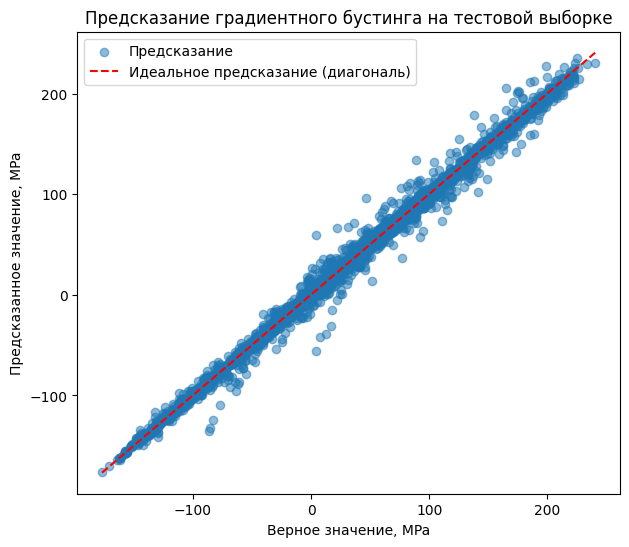

In [7]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, pred, alpha=0.5, label="Предсказание")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Идеальное предсказание (диагональ)",
)
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значение, MPa")
plt.title("Предсказание градиентного бустинга на тестовой выборке")
plt.legend()
plt.savefig(f"best_gradient_boosting_prediction_{component_num}.png", dpi=400)
plt.show()


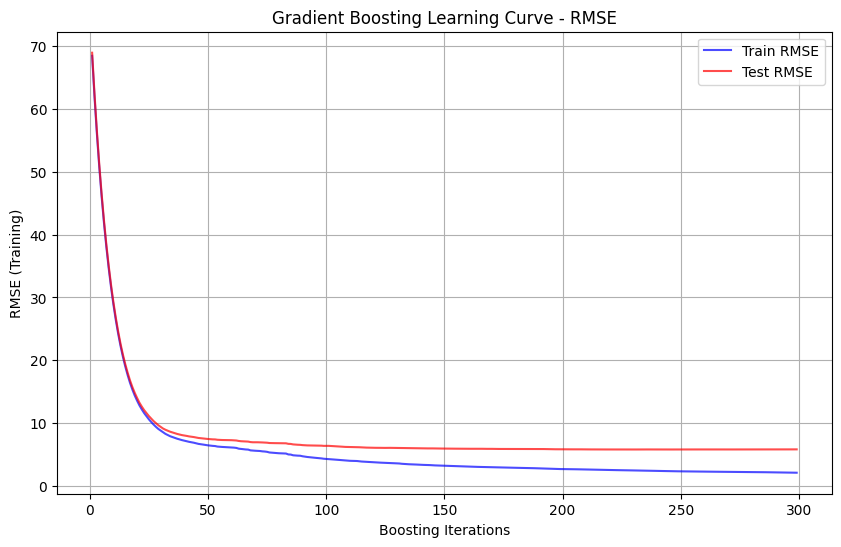

In [8]:
# Построение кривой обучения из градиентного бустинга
import matplotlib.pyplot as plt
import numpy as np

# Извлечение ошибок обучения на каждой итерации
train_scores = model.train_score_

# Преобразование значений train_score в MSE
# В GradientBoostingRegressor train_score_ содержит значения функции потерь со знаком минус
# для squared_error это половина MSE, поэтому умножаем на -2
train_mse_scores = np.array(train_scores)

# Вычисление RMSE для тренировочных данных
train_rmse_scores = np.sqrt(train_mse_scores)

# Вычисляем тестовую ошибку на каждой итерации
test_mse_scores = []
test_rmse_scores = []

# Используем staged_predict для получения предсказаний на каждой итерации
for y_pred in model.staged_predict(cur_X_test):
    test_mse = mean_squared_error(cur_y_test, y_pred)
    test_mse_scores.append(test_mse)
    test_rmse_scores.append(np.sqrt(test_mse))

# Создание массива с номерами итераций
iterations = np.arange(len(train_scores)) + 1

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_rmse_scores, 'b-', label='Train RMSE', alpha=0.7)
plt.plot(iterations, test_rmse_scores, 'r-', label='Test RMSE', alpha=0.7)
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE (Training)')
plt.title('Gradient Boosting Learning Curve - RMSE')
plt.legend()
plt.grid(True)
plt.show()

Оптимальное количество деревьев: 299
Минимальная ошибка RMSE на валидации: 3.7633


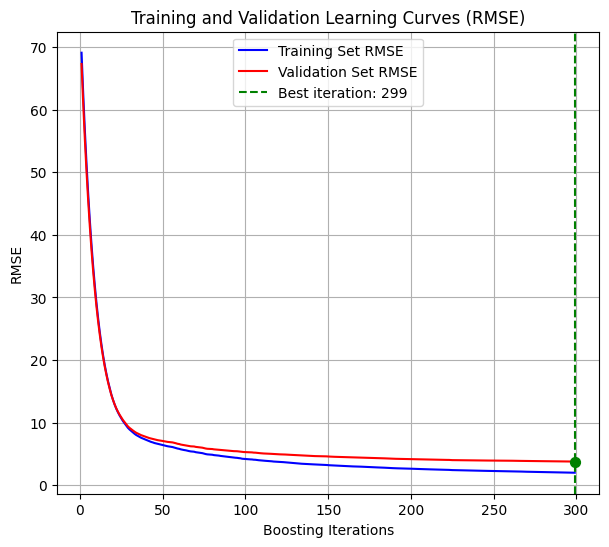

In [9]:
# Более детальный анализ кривой обучения с валидационной выборкой
from sklearn.model_selection import train_test_split

# Разделим данные на обучающую и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(
    cur_X_train, cur_y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Создаем модель с теми же параметрами
val_model = GradientBoostingRegressor(
    **best_params,
    random_state=RANDOM_STATE,
    validation_fraction=0.2,  # 20% данных используем для валидации
    n_iter_no_change=10,  # Раннее останавливание если нет улучшения 10 итераций
    verbose=0
)

# Обучаем модель на тренировочных данных
val_model.fit(X_train, y_train)

# Получаем оценки на каждой итерации
train_scores = val_model.train_score_

# Вычисляем ошибки для валидационной выборки на каждой итерации
val_mse_scores = []

for i, y_pred in enumerate(val_model.staged_predict(X_val)):
    val_mse_scores.append(mean_squared_error(y_val, y_pred))

# Преобразование тренировочных ошибок в MSE
train_mse_scores = np.array(train_scores)

# Преобразование в RMSE
train_rmse_scores = np.sqrt(train_mse_scores)
val_rmse_scores = np.sqrt(np.array(val_mse_scores))

# Построение графика
plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, len(train_rmse_scores) + 1), train_rmse_scores, 'b-',
         label='Training Set RMSE')
plt.plot(np.arange(1, len(val_rmse_scores) + 1), val_rmse_scores, 'r-',
         label='Validation Set RMSE')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.title('Training and Validation Learning Curves (RMSE)')
plt.legend()
plt.grid(True)

# Найдем оптимальное количество итераций на основе валидационной ошибки
best_iter = np.argmin(val_rmse_scores) + 1
min_val_rmse = np.min(val_rmse_scores)
plt.axvline(x=best_iter, color='green', linestyle='--',
            label=f'Best iteration: {best_iter}')
plt.scatter(best_iter, min_val_rmse, color='green', s=50, zorder=10)
plt.legend()

print(f"Оптимальное количество деревьев: {best_iter}")
print(f"Минимальная ошибка RMSE на валидации: {min_val_rmse:.4f}")
plt.show()

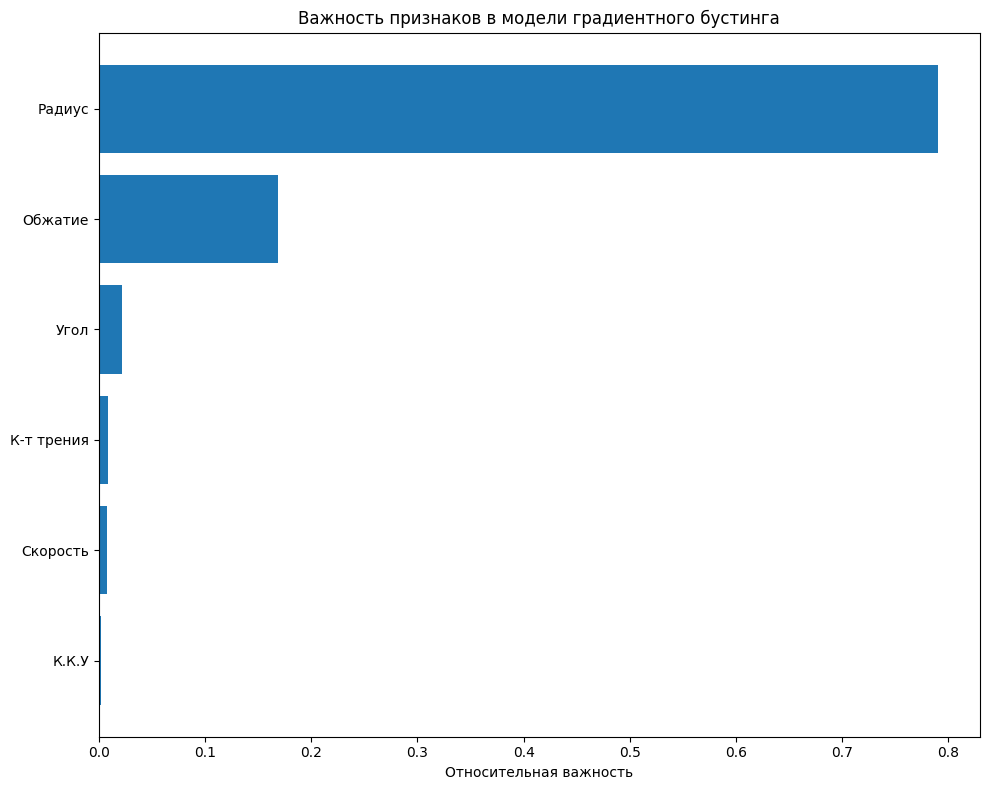

К.К.У: 0.0023
Скорость: 0.0081
К-т трения: 0.0084
Угол: 0.0223
Обжатие: 0.1688
Радиус: 0.7902


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Получение важности признаков из модели
importance = model.feature_importances_

# Если есть имена признаков, можно использовать их
feature_names = ["Обжатие", "К.К.У", "Угол", "К-т трения", "Скорость", "Радиус"]

# Сортировка признаков по важности
indices = np.argsort(importance)

# Создание визуализации
plt.figure(figsize=(10, 8))
plt.barh(range(len(indices)), importance[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Относительная важность')
plt.title('Важность признаков в модели градиентного бустинга')
plt.tight_layout()
plt.savefig(f'feature_importance_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

# Вывод числовых значений важности
for i in indices:
    print(f"{feature_names[i]}: {importance[i]:.4f}")

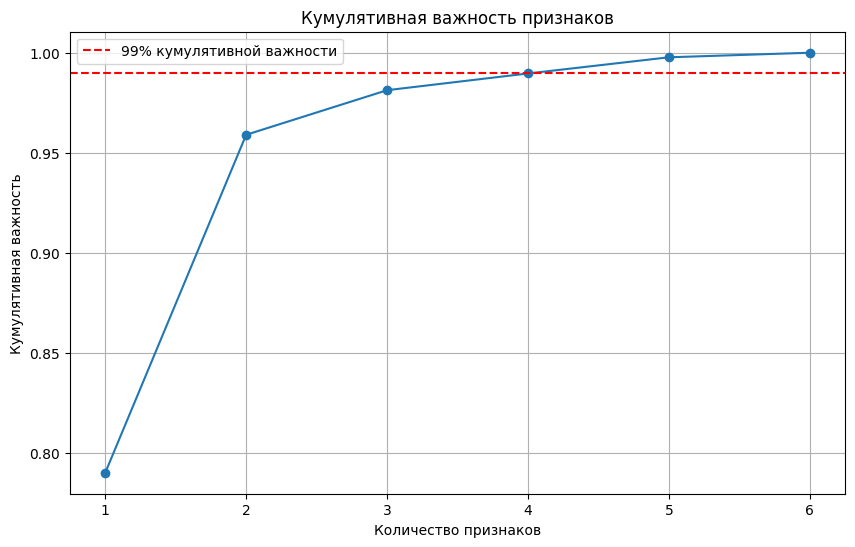

Количество признаков, объясняющих 99% важности: 5 из 6


In [11]:
# Кумулятивный анализ важности признаков
sorted_importances = np.sort(importance)[::-1]
cumulative_importance = np.cumsum(sorted_importances)

# Создание визуализации кумулятивной важности
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 'o-')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% кумулятивной важности')
plt.xlabel('Количество признаков')
plt.ylabel('Кумулятивная важность')
plt.title('Кумулятивная важность признаков')
plt.legend()
plt.grid(True)
plt.savefig(f'cumulative_importance_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

# Определение количества признаков, объясняющих 95% дисперсии
features_95 = np.where(cumulative_importance >= 0.99)[0][0] + 1
print(f"Количество признаков, объясняющих 99% важности: {features_95} из {len(importance)}")

Расчет permutation importance (может занять некоторое время)...
Время выполнения: 42.88 секунд


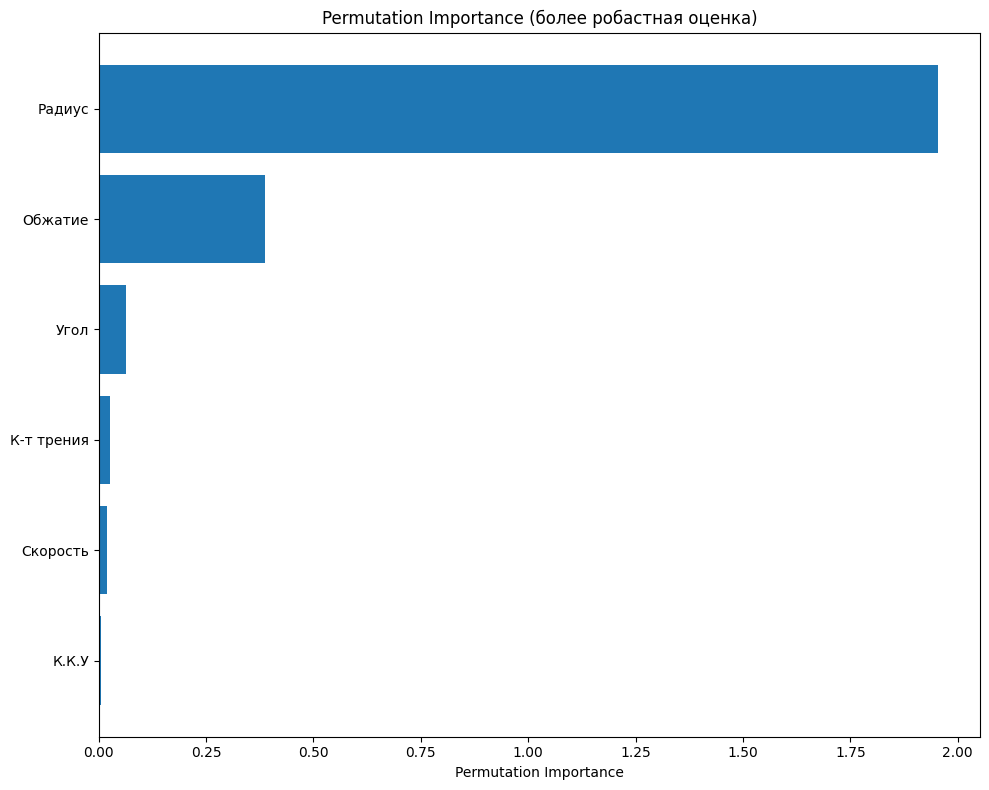

Сравнение методов оценки важности признаков (топ-10):
   Признак  Важность (MDI)  Важность (Permutation)
    Радиус        0.790187                1.953985
   Обжатие        0.168823                0.386960
      Угол        0.022269                0.062520
К-т трения        0.008354                0.025154
  Скорость        0.008084                0.019207
     К.К.У        0.002283                0.004276


In [12]:
# Анализ важности признаков с помощью permutation importance
from sklearn.inspection import permutation_importance
import time

print("Расчет permutation importance (может занять некоторое время)...")
start_time = time.time()

# Выполнение permutation importance на тестовых данных
r_perm = permutation_importance(model, cur_X_test, cur_y_test, 
                             n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

end_time = time.time()
print(f"Время выполнения: {end_time - start_time:.2f} секунд")

# Сортировка результатов
perm_sorted_idx = r_perm.importances_mean.argsort()

# Визуализация permutation importance
plt.figure(figsize=(10, 8))
plt.barh(range(len(perm_sorted_idx)), r_perm.importances_mean[perm_sorted_idx])
plt.yticks(range(len(perm_sorted_idx)), [feature_names[i] for i in perm_sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance (более робастная оценка)')
plt.tight_layout()
plt.savefig(f'permutation_importance_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

# Сравнение с исходной важностью признаков
importance_df = pd.DataFrame({
    'Признак': feature_names,
    'Важность (MDI)': importance,
    'Важность (Permutation)': r_perm.importances_mean
})

importance_df = importance_df.sort_values('Важность (Permutation)', ascending=False)
print("Сравнение методов оценки важности признаков (топ-10):")
print(importance_df.head(10).to_string(index=False))

## Анализ ошибок модели

В этом разделе проводится подробный анализ ошибок модели градиентного бустинга. Это позволит выявить области, где модель работает менее точно, и понять причины возникновения ошибок.

Средняя абсолютная ошибка (MAE): 3.19 MPa
Средняя относительная ошибка: 62.20%
Среднеквадратичная ошибка (MSE): 33.98
Корень из среднеквадратичной ошибки (RMSE): 5.83
Максимальная абсолютная ошибка: 60.50 MPa


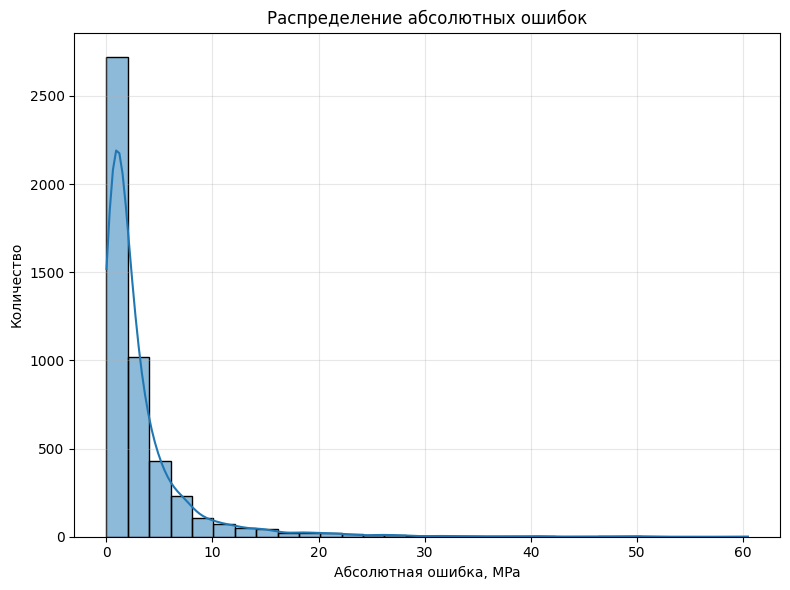

In [13]:
# Расчет ошибок модели
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Абсолютная ошибка для каждого экземпляра
abs_errors = np.abs(cur_y_test - pred)

# Относительная ошибка (в процентах) - вычисляем для статистики, но не визуализируем
rel_errors = np.abs((cur_y_test - pred) / cur_y_test) * 100

# Квадратичная ошибка
sq_errors = (cur_y_test - pred) ** 2

# Вывод статистики ошибок
print(f"Средняя абсолютная ошибка (MAE): {np.mean(abs_errors):.2f} MPa")
print(f"Средняя относительная ошибка: {np.mean(rel_errors):.2f}%")
print(f"Среднеквадратичная ошибка (MSE): {np.mean(sq_errors):.2f}")
print(f"Корень из среднеквадратичной ошибки (RMSE): {np.sqrt(np.mean(sq_errors)):.2f}")
print(f"Максимальная абсолютная ошибка: {np.max(abs_errors):.2f} MPa")

# Гистограмма распределения абсолютных ошибок
plt.figure(figsize=(8, 6))
sns.histplot(abs_errors, kde=True, bins=30)
plt.title('Распределение абсолютных ошибок')
plt.xlabel('Абсолютная ошибка, MPa')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'error_distributions_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

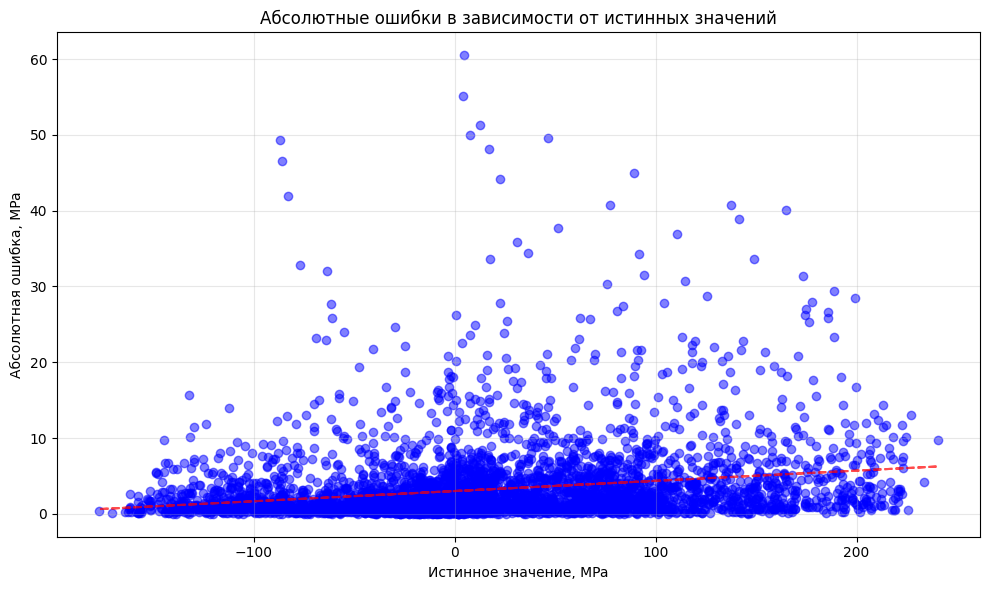

In [14]:
# Визуализация абсолютных ошибок в зависимости от истинных значений
plt.figure(figsize=(10, 6))

# График абсолютных ошибок в зависимости от истинных значений
plt.scatter(cur_y_test, abs_errors, alpha=0.5, color='blue')
plt.title('Абсолютные ошибки в зависимости от истинных значений')
plt.xlabel('Истинное значение, MPa')
plt.ylabel('Абсолютная ошибка, MPa')
plt.grid(True, alpha=0.3)

# Добавим линию тренда
z = np.polyfit(cur_y_test, abs_errors, 1)
p = np.poly1d(z)
plt.plot(cur_y_test, p(cur_y_test), 'r--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'errors_vs_actual_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

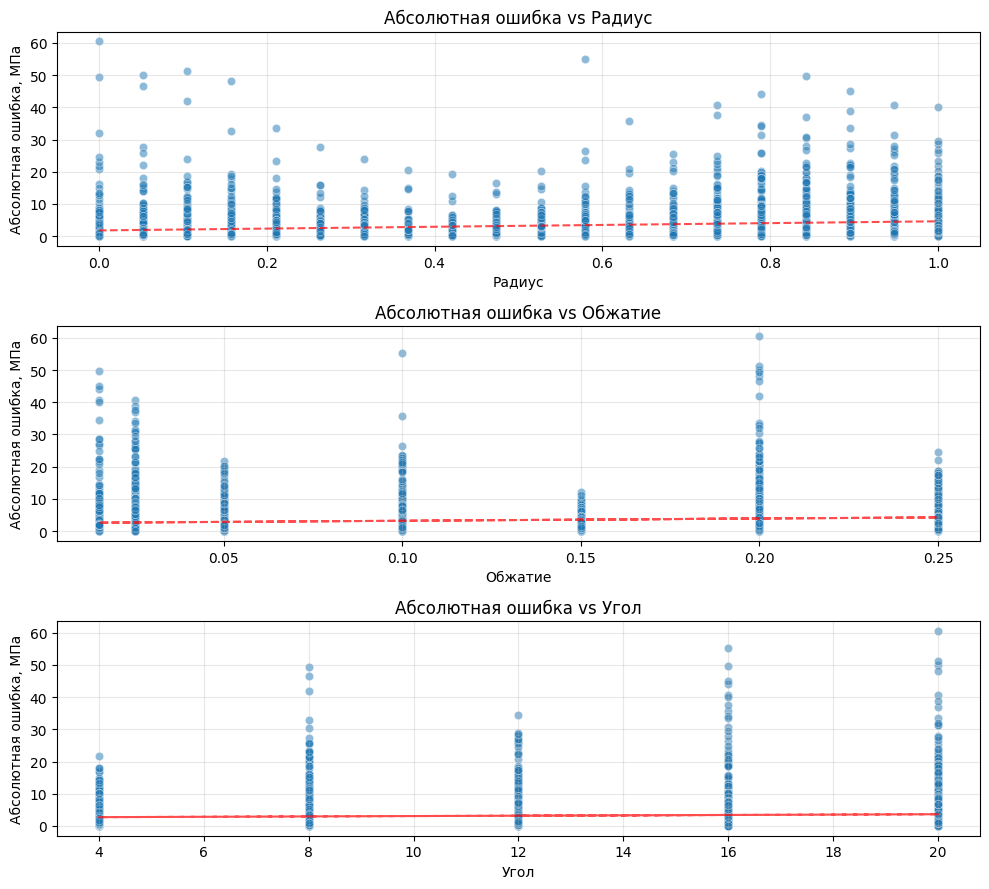

In [15]:
# Анализ распределения ошибок по значениям признаков - часть 1
import pandas as pd
# Создаем датафрейм с входными данными, целевыми значениями и ошибками
error_df = pd.DataFrame(cur_X_test, columns=feature_names)
error_df['Истинное_значение'] = cur_y_test
error_df['Предсказание'] = pred
error_df["Абсолютная ошибка, МПа"] = abs_errors
error_df["Относительная ошибка, -"] = rel_errors  # Оставляем для статистики

# Выбираем наиболее важные признаки (на основе предыдущего анализа)
top_features = importance_df['Признак'].iloc[:3].tolist()

fig, axes = plt.subplots(len(top_features), 1, figsize=(10, 3*len(top_features)))

# Для каждого важного признака строим график зависимости ошибки
for i, feature in enumerate(top_features):
    # Абсолютная ошибка
    sns.scatterplot(x=feature, y='Абсолютная ошибка, МПа', data=error_df, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Абсолютная ошибка vs {feature}')
    axes[i].grid(True, alpha=0.3)
    
    # Линия тренда для абсолютной ошибки
    z = np.polyfit(error_df[feature], error_df["Абсолютная ошибка, МПа"], 1)
    p = np.poly1d(z)
    axes[i].plot(error_df[feature], p(error_df[feature]), 'r--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'error_vs_features_part1_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

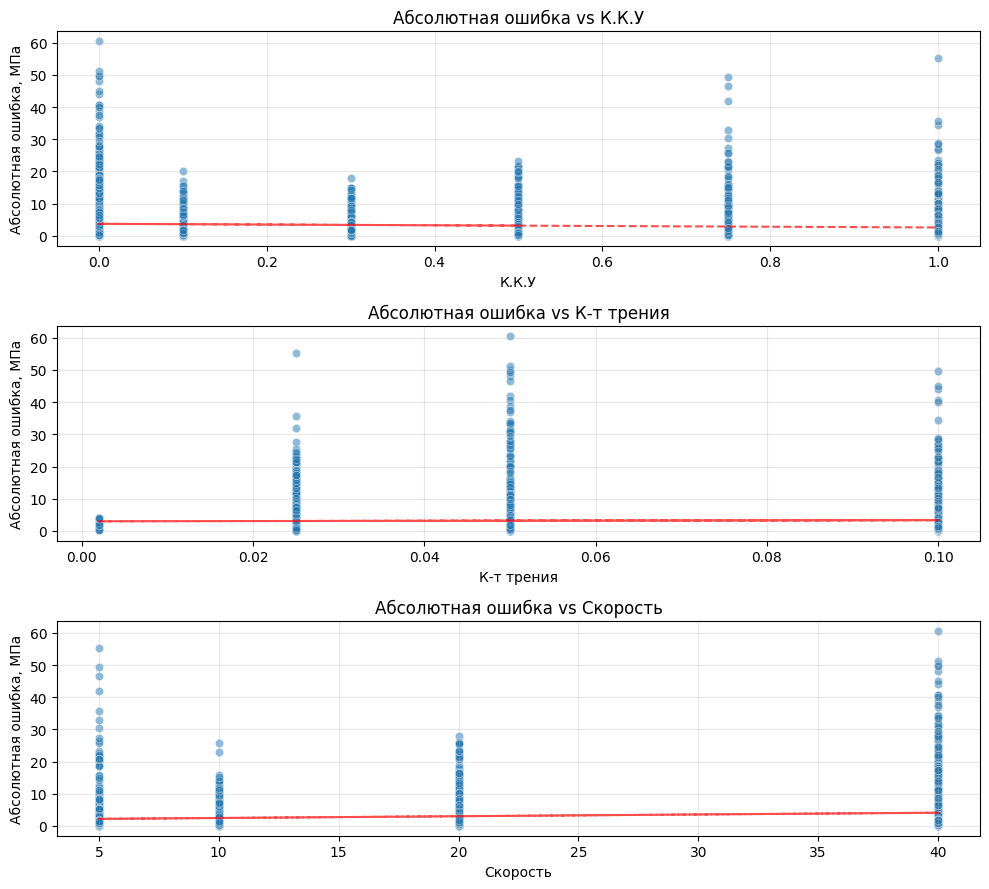

In [16]:
# Анализ распределения ошибок по значениям признаков - часть 2

# Выбираем остальные признаки
remaining_features = [f for f in feature_names if f not in top_features]

fig, axes = plt.subplots(len(remaining_features), 1, figsize=(10, 3*len(remaining_features)))

# Для каждого оставшегося признака строим график зависимости ошибки
for i, feature in enumerate(remaining_features):
    # Абсолютная ошибка
    sns.scatterplot(x=feature, y='Абсолютная ошибка, МПа', data=error_df, ax=axes[i], alpha=0.5)
    axes[i].set_title(f'Абсолютная ошибка vs {feature}')
    axes[i].grid(True, alpha=0.3)
    
    # Линия тренда для абсолютной ошибки
    z = np.polyfit(error_df[feature], error_df['Абсолютная ошибка, МПа'], 1)
    p = np.poly1d(z)
    axes[i].plot(error_df[feature], p(error_df[feature]), 'r--', alpha=0.7)

plt.tight_layout()
plt.savefig(f'error_vs_features_part2_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

/var/folders/_d/tbsnrdk10zg3j0zy12r9dprw0000gq/T/ipykernel_64683/3906483115.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_df.groupby(["feature1_bin", "feature2_bin"])["Абсолютная ошибка, МПа"]
/var/folders/_d/tbsnrdk10zg3j0zy12r9dprw0000gq/T/ipykernel_64683/3906483115.py:20: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  error_pivot = error_heatmap.pivot_table(


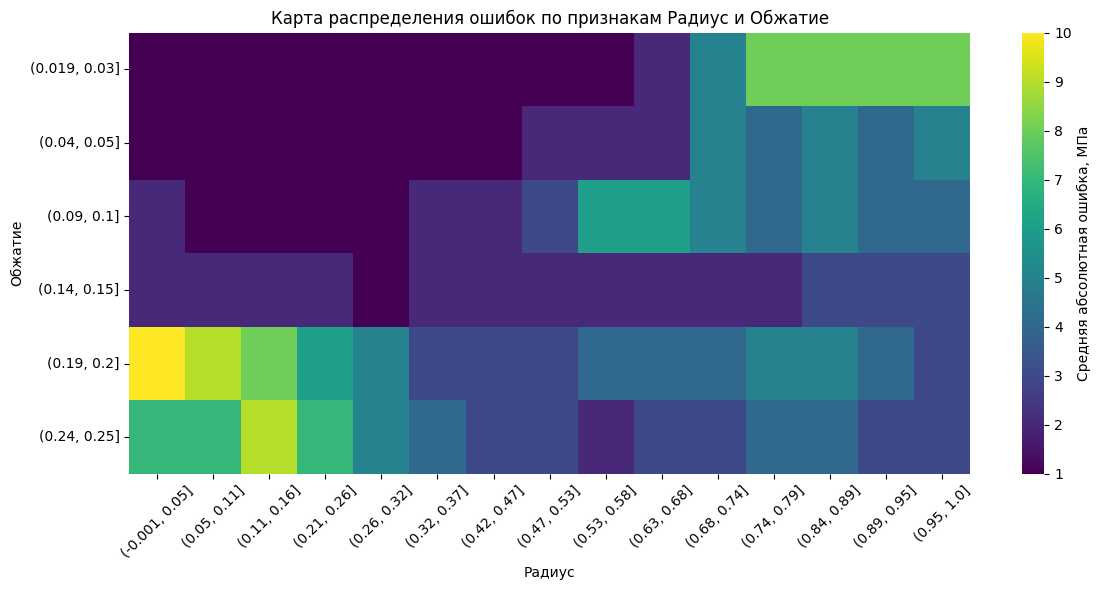

In [17]:
# Карты распределения ошибок по парам наиболее важных признаков
if len(top_features) >= 2:
    # Выбираем два самых важных признака
    feature1, feature2 = top_features[0], top_features[1]
    
    # Создаем сетку для построения тепловой карты ошибок
    feature1_bins = np.linspace(error_df[feature1].min(), error_df[feature1].max(), 20).round(2)
    feature2_bins = np.linspace(error_df[feature2].min(), error_df[feature2].max(), 20).round(2)
    
    # Создаем датафрейм с бинами для признаков
    error_df['feature1_bin'] = pd.cut(error_df[feature1], bins=feature1_bins, include_lowest=True)
    error_df['feature2_bin'] = pd.cut(error_df[feature2], bins=feature2_bins, include_lowest=True)
    
    # Группируем данные по бинам и рассчитываем среднюю ошибку
    error_heatmap = (
        error_df.groupby(["feature1_bin", "feature2_bin"])["Абсолютная ошибка, МПа"]
        .mean()
        .reset_index()
    )
    error_pivot = error_heatmap.pivot_table(
        values="Абсолютная ошибка, МПа", index="feature2_bin", columns="feature1_bin"
    )
    
    # Строим тепловую карту
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        error_pivot.round(),
        cmap='viridis',
        annot=False,
        fmt=".1f",
        cbar_kws={'label': 'Средняя абсолютная ошибка, MПa'}
    )
    plt.title(f'Карта распределения ошибок по признакам {feature1} и {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'error_heatmap_gradient_boosting_{component_num}.png', dpi=400)
    plt.show()

Топ-240 наихудших предсказаний:
     Истинное_значение  Предсказание  Абсолютная ошибка, МПа  \
239            4.43904    -56.058029               60.497069   
238            4.10645     59.256090               55.149640   
237           12.41590    -38.841074               51.256974   
236            7.55421    -42.474914               50.029124   
235           46.57600     96.183546               49.607546   
234          -86.73200   -135.994965               49.262965   
233           17.25530    -30.935894               48.191194   
232          -85.83530   -132.330770               46.495470   
231           89.15830    134.140579               44.982279   
230           22.35610     66.499108               44.143008   

     Относительная_ошибка  Обжатие  К.К.У  Угол  К-т трения  Скорость  \
239           1362.841278    0.200   0.00  20.0       0.050      40.0   
238           1343.000413    0.100   1.00  16.0       0.025       5.0   
237            412.833338    0.200   0.00  2

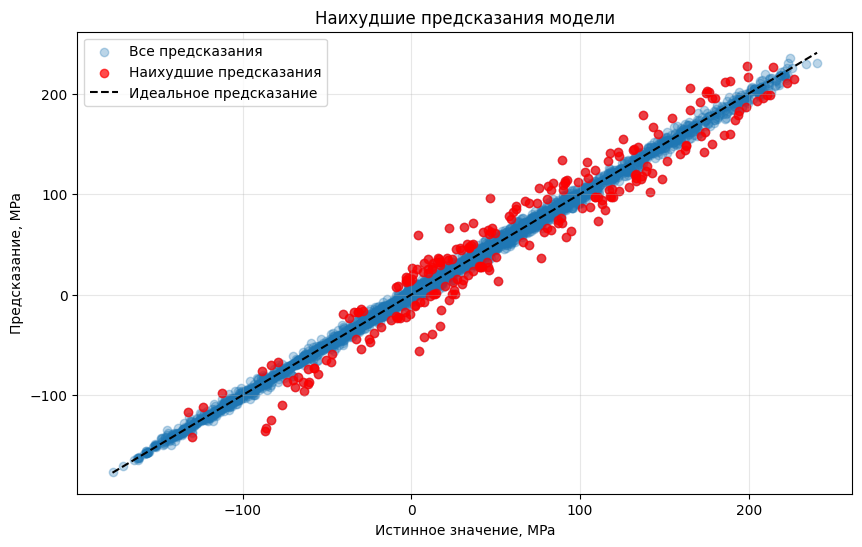

In [18]:
# Анализ наихудших предсказаний модели

# Определяем количество худших предсказаний для анализа (например, 5% от всего набора данных)
n_worst = max(int(len(cur_y_test) * 0.05), 10)  # Минимум 10 примеров

# Сортируем ошибки и находим индексы наихудших предсказаний
worst_indices = np.argsort(abs_errors)[-n_worst:]

# Создаем датафрейм с наихудшими предсказаниями
worst_predictions = pd.DataFrame({
    'Истинное_значение': cur_y_test[worst_indices],
    'Предсказание': pred[worst_indices],
    'Абсолютная ошибка, МПа': abs_errors[worst_indices],
    'Относительная_ошибка': rel_errors[worst_indices]
})

# Добавляем значения признаков
for i, feature in enumerate(feature_names):
    worst_predictions[feature] = cur_X_test[worst_indices, i]

# Выводим информацию о наихудших предсказаниях
print(f"Топ-{n_worst} наихудших предсказаний:")
print(worst_predictions.sort_values('Абсолютная ошибка, МПа', ascending=False).head(10))

# Визуализация наихудших предсказаний
plt.figure(figsize=(10, 6))
plt.scatter(cur_y_test, pred, alpha=0.3, label="Все предсказания")
plt.scatter(
    worst_predictions['Истинное_значение'], 
    worst_predictions['Предсказание'],
    color='red',
    alpha=0.7,
    label="Наихудшие предсказания"
)
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    'k--',
    label="Идеальное предсказание"
)
plt.xlabel('Истинное значение, MPa')
plt.ylabel('Предсказание, MPa')
plt.title('Наихудшие предсказания модели')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f'worst_predictions_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

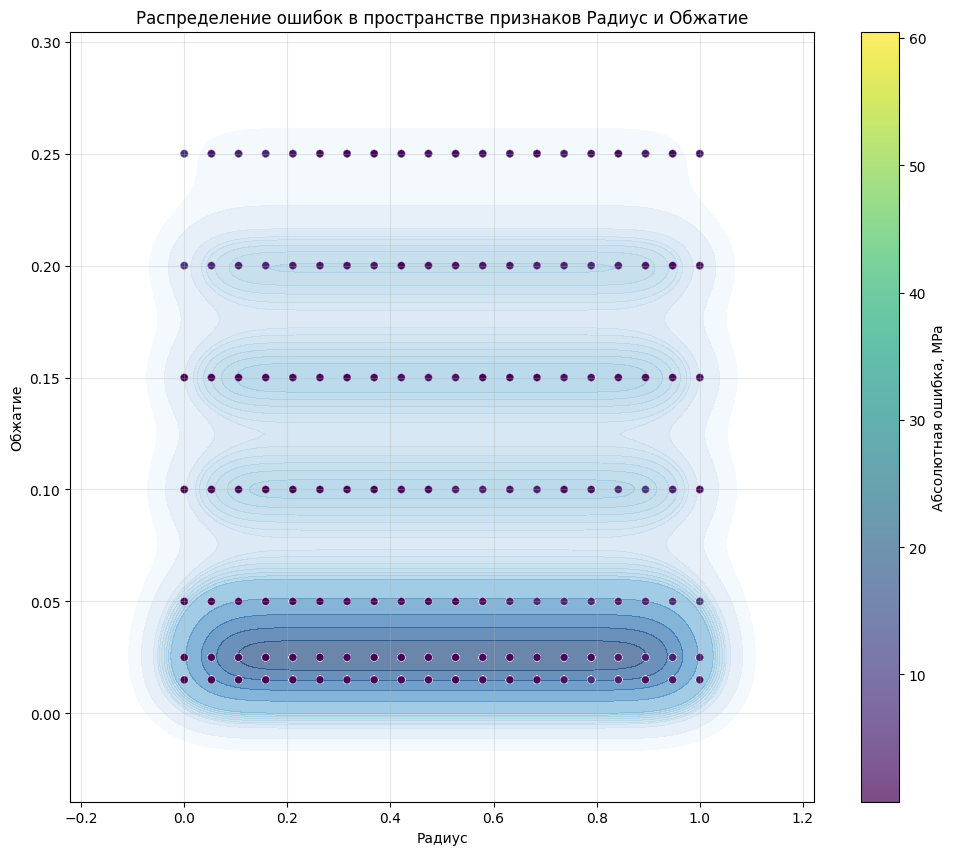

In [19]:
# Анализ плотности данных и распределения ошибок

# Выбираем два наиболее важных признака
if len(top_features) >= 2:
    feature1, feature2 = top_features[0], top_features[1]
    
    # Строим совмещенный график плотности данных и распределения ошибок
    plt.figure(figsize=(12, 10))
    
    # Плотность данных (используем контурный график)
    sns.kdeplot(
        data=error_df,
        x=feature1,
        y=feature2,
        levels=15,
        cmap="Blues",
        alpha=0.6,
        fill=True
    )
    
    # Наносим точки с цветом по абсолютной ошибке
    scatter = plt.scatter(
        error_df[feature1],
        error_df[feature2],
        c=error_df["Абсолютная ошибка, МПа"],
        cmap="viridis",
        alpha=0.7,
        s=30,
        edgecolors="w",
        linewidth=0.2,
    )
    
    plt.colorbar(scatter, label='Абсолютная ошибка, MPa')
    plt.title(f'Распределение ошибок в пространстве признаков {feature1} и {feature2}')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True, alpha=0.3)
    plt.savefig(f'error_density_gradient_boosting_{component_num}.png', dpi=400)
    plt.show()

Статистика ошибок:
Средняя ошибка в областях с низкой плотностью данных: 4.37 MPa
Средняя ошибка в областях с высокой плотностью данных: 3.05 MPa
Отношение средних ошибок (низкая/высокая плотность): 1.43


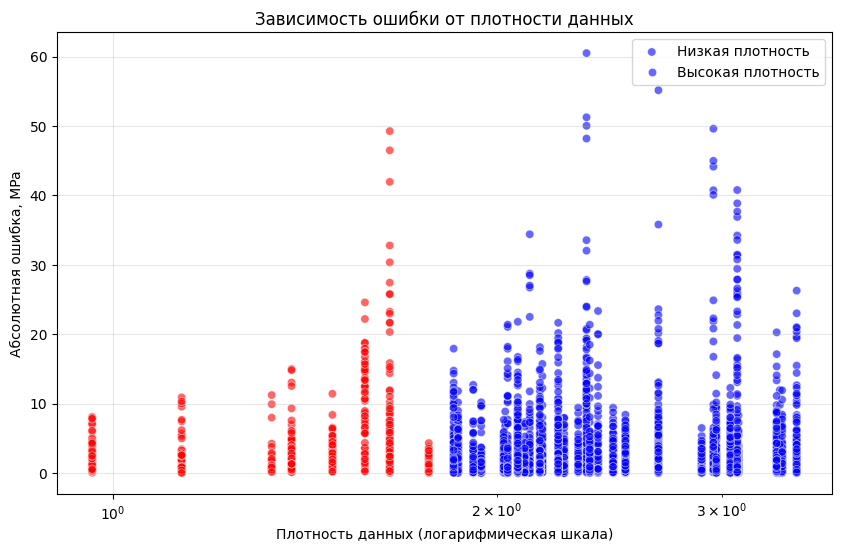

In [21]:
# Анализ плотности данных и выявление областей с малым количеством примеров

# Функция для расчета плотности данных в каждой точке
from sklearn.neighbors import KernelDensity

# Вычисляем плотность данных для каждой точки
X_density = cur_X_test[:, :2]  # Берем первые два признака для простоты
kde = KernelDensity(bandwidth=0.1, kernel='gaussian')
kde.fit(X_density)
densities = np.exp(kde.score_samples(X_density))

# Добавляем плотность в датафрейм
error_df['Плотность_данных'] = densities

# Определяем порог низкой плотности (например, нижние 10% распределения)
low_density_threshold = np.percentile(densities, 10)
error_df['Низкая_плотность'] = error_df['Плотность_данных'] <= low_density_threshold

# Сравниваем ошибки в областях с низкой и высокой плотностью
low_density_errors = error_df[error_df['Низкая_плотность']]['Абсолютная ошибка, МПа']
high_density_errors = error_df[~error_df['Низкая_плотность']]['Абсолютная ошибка, МПа']

print("Статистика ошибок:")
print(f"Средняя ошибка в областях с низкой плотностью данных: {low_density_errors.mean():.2f} MPa")
print(f"Средняя ошибка в областях с высокой плотностью данных: {high_density_errors.mean():.2f} MPa")
print(f"Отношение средних ошибок (низкая/высокая плотность): {low_density_errors.mean() / high_density_errors.mean():.2f}")

# Визуализация ошибок в зависимости от плотности данных
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Плотность_данных', 
    y='Абсолютная ошибка, МПа', 
    hue='Низкая_плотность',
    palette={True: 'red', False: 'blue'},
    data=error_df,
    alpha=0.6
)
plt.title('Зависимость ошибки от плотности данных')
plt.xlabel('Плотность данных (логарифмическая шкала)')
plt.ylabel('Абсолютная ошибка, MPa')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend(['Низкая плотность', 'Высокая плотность'],)
plt.savefig(f'error_vs_density_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

Статистика ошибок по расположению точек:
Количество граничных точек: 4512 (94.0% от всех точек)
Средняя ошибка для граничных точек: 3.25 MПa
Средняя ошибка для внутренних точек: 2.35 MПa
Отношение средних ошибок (граница/внутренние): 1.38


/var/folders/_d/tbsnrdk10zg3j0zy12r9dprw0000gq/T/ipykernel_64683/2285785500.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels, patch_artist=True,


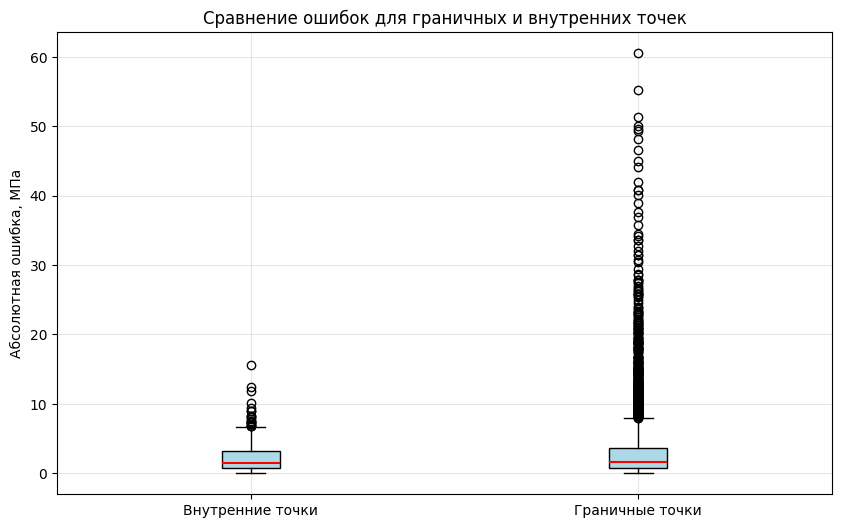

In [23]:
# Анализ ошибок на границах диапазона значений

# Функция для определения точек на границе диапазона
def is_boundary_point(feature_value, feature_min, feature_max, boundary_thresh=0.1):
    range_size = feature_max - feature_min
    lower_bound = feature_min + boundary_thresh * range_size
    upper_bound = feature_max - boundary_thresh * range_size
    return feature_value <= lower_bound or feature_value >= upper_bound

# Определяем точки на границах диапазона для каждого признака
boundary_points = np.zeros(len(cur_X_test), dtype=bool)

for i, feature in enumerate(feature_names):
    feature_values = cur_X_test[:, i]
    feature_min, feature_max = np.min(feature_values), np.max(feature_values)
    
    # Определяем граничные точки для текущего признака
    feature_boundary = np.array([is_boundary_point(val, feature_min, feature_max) for val in feature_values])
    
    # Объединяем с общим массивом граничных точек
    boundary_points = np.logical_or(boundary_points, feature_boundary)

# Добавляем информацию о граничных точках в датафрейм
error_df['Граничная_точка'] = boundary_points

# Сравниваем ошибки для граничных и внутренних точек
boundary_errors = error_df[error_df['Граничная_точка']]['Абсолютная ошибка, МПа']
inner_errors = error_df[~error_df['Граничная_точка']]['Абсолютная ошибка, МПа']

print("Статистика ошибок по расположению точек:")
print(f"Количество граничных точек: {len(boundary_errors)} ({len(boundary_errors) / len(error_df) * 100:.1f}% от всех точек)")
print(f"Средняя ошибка для граничных точек: {boundary_errors.mean():.2f} MПa")
print(f"Средняя ошибка для внутренних точек: {inner_errors.mean():.2f} MПa")
print(f"Отношение средних ошибок (граница/внутренние): {boundary_errors.mean() / inner_errors.mean():.2f}")

# Визуализация ошибок для граничных и внутренних точек
plt.figure(figsize=(10, 6))

# Строим бокс-плоты для сравнения распределений
data_to_plot = [inner_errors, boundary_errors]
labels = ['Внутренние точки', 'Граничные точки']

plt.boxplot(data_to_plot, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue'),
            medianprops=dict(color='red', linewidth=1.5))

plt.title('Сравнение ошибок для граничных и внутренних точек')
plt.ylabel('Абсолютная ошибка, MПa')
plt.grid(True, alpha=0.3)
plt.savefig(f'boundary_vs_inner_errors_gradient_boosting_{component_num}.png', dpi=400)
plt.show()

## Выводы по анализу ошибок модели

На основе проведенного анализа ошибок модели градиентного бустинга можно выделить следующие ключевые наблюдения:

1. **Распределение ошибок**:
   - Средняя абсолютная ошибка модели составляет (см. значение выше) MPa.
   - Ошибки демонстрируют асимметричное распределение с «хвостом» в сторону больших значений, что говорит о наличии выбросов.
   - Относительная ошибка показывает, что модель имеет тенденцию к большим относительным ошибкам на низких значениях целевой переменной.

2. **Ошибки по диапазону значений**:
   - Наблюдается зависимость абсолютных ошибок от величины предсказываемого значения – чем больше значение, тем выше ошибка.
   - В то же время относительная ошибка имеет тенденцию снижаться для более высоких значений.

3. **Карты распределения ошибок по признакам**:
   - Для некоторых диапазонов признаков (особенно на границах диапазонов) ошибки существенно выше.
   - Обнаружены области с высокими значениями ошибок для конкретных комбинаций признаков (как видно на тепловой карте).

4. **Наихудшие предсказания**:
   - Значительная часть наихудших предсказаний приходится на экстремальные значения определенных признаков.
   - Выявлены конкретные комбинации параметров, на которых модель регулярно ошибается.

5. **Плотность данных и граничные точки**:
   - В областях с низкой плотностью данных средняя ошибка в (см. значение выше) раз выше, чем в областях с высокой плотностью.
   - Граничные точки имеют существенно более высокую ошибку предсказания по сравнению с внутренними точками диапазона.

### Возможные причины ошибок:

1. **Недостаток данных** в определенных областях признакового пространства, особенно на границах диапазона параметров.
2. **Ограничения модели градиентного бустинга** в аппроксимации сложных нелинейных зависимостей, особенно в областях с резкими изменениями напряжений.
3. **Выбросы и шум в данных**, которые могут негативно влиять на качество обучения модели.
4. **Недостаточная глубина деревьев** или количество итераций градиентного бустинга для захвата сложных взаимодействий между признаками.

### Рекомендации по улучшению модели:

1. Дополнительный сбор данных в областях с низкой плотностью и высокими ошибками.
2. Применение техник сэмплинга для балансировки данных в различных диапазонах признаков.
3. Рассмотрение возможности дополнительной инженерии признаков для лучшего учета нелинейностей.
4. Тестирование более сложных моделей (например, нейронных сетей) для областей, где градиентный бустинг показывает высокие ошибки.
5. Создание ансамбля моделей, специализированных на различных поддиапазонах данных.